In [ ]:
import netCDF4 as nc 
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
import geopandas as gpd 

import cartopy.crs as ccrs 
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

from shapely.geometry import Point

from datetime import datetime

from sklearn.decomposition import PCA

In [5]:
# Load GRACE data
file_path = '../data/CSR_GRACE_GRACE-FO_RL0603_Mascons_all-corrections.nc'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")
mascons = nc.Dataset(file_path)

# Define fill value
fill_value = 9.969209968386869e+36

# Extract GRACE variables
lat = mascons.variables['lat'][:]
lon = mascons.variables['lon'][:]
data = mascons.variables['lwe_thickness'][:]  # Shape: (time, lat, lon)

# Create a GeoDataFrame for the GRACE mascon grid points
lon_grid, lat_grid = np.meshgrid(lon, lat)
points = gpd.GeoSeries([Point(xy) for xy in zip(lon_grid.ravel(), lat_grid.ravel())], crs='EPSG:4326')

# Load the simplified Caspian Basin polygon
gdf_simplified = gpd.read_file("../data/caspian_basin_no_holes.geojson")
caspian_basin_geom = gdf_simplified.geometry.iloc[0]  # Get the geometry

# Create a mask for valid (non-fill) data
valid_mask = data[0] != fill_value  # Use first time step to determine valid grid cells

# Apply geographic constraints (bounding box first)
lat_mask = (lat_grid >= 33) & (lat_grid <= 63)
lon_mask = (lon_grid >= 32) & (lon_grid <= 70)
bbox_mask = valid_mask & lat_mask & lon_mask

# Convert only candidate points to a GeoDataFrame
candidate_points = points[bbox_mask.flatten()]

# Check which points are inside the Caspian Basin polygon
inside_mask = np.full(bbox_mask.shape, False)  # Create an empty mask
inside_mask[bbox_mask] = candidate_points.within(caspian_basin_geom).values  # Apply only to candidates


# Combine masks: Only keep points inside the basin & valid data
final_mask = valid_mask & inside_mask

# Apply mask to retain only valid data points
data_valid = np.where(final_mask[None, :, :], data, np.nan)  # Shape: (time, lat, lon)
data_valid = data_valid[:, final_mask]  # Collapse spatial dimensions (time, num_valid_mascons)

# Reshape for PCA
time_len, num_valid_mascons = data_valid.shape
data_2d = data_valid.reshape(time_len, num_valid_mascons)

# Center data
time_mean = np.nanmean(data_2d, axis=0)
data_centered = data_2d - time_mean

# Apply PCA
pca = PCA(n_components=3)
pca.fit(data_centered)

# Get transformed data (Principal Components)
t_data = pca.transform(data_centered)

# Explained variance ratio
e_var = pca.explained_variance_ratio_
print("Explained variance ratio for the first 3 EOFs (Exact Caspian Basin):", e_var)


C:\Users\tobia\AppData\Local\Temp\ipykernel_22924\1143930093.py:11: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  lat = mascons.variables['lat'][:]
C:\Users\tobia\AppData\Local\Temp\ipykernel_22924\1143930093.py:11: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  lat = mascons.variables['lat'][:]
C:\Users\tobia\AppData\Local\Temp\ipykernel_22924\1143930093.py:12: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  lon = mascons.variables['lon'][:]
C:\Users\tobia\AppData\Local\Temp\ipykernel_22924\1143930093.py:12: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  lon = mascons.variables['lon'][:]


Explained variance ratio for the first 3 EOFs (Exact Caspian Basin): [0.8349357  0.08070213 0.01726664]


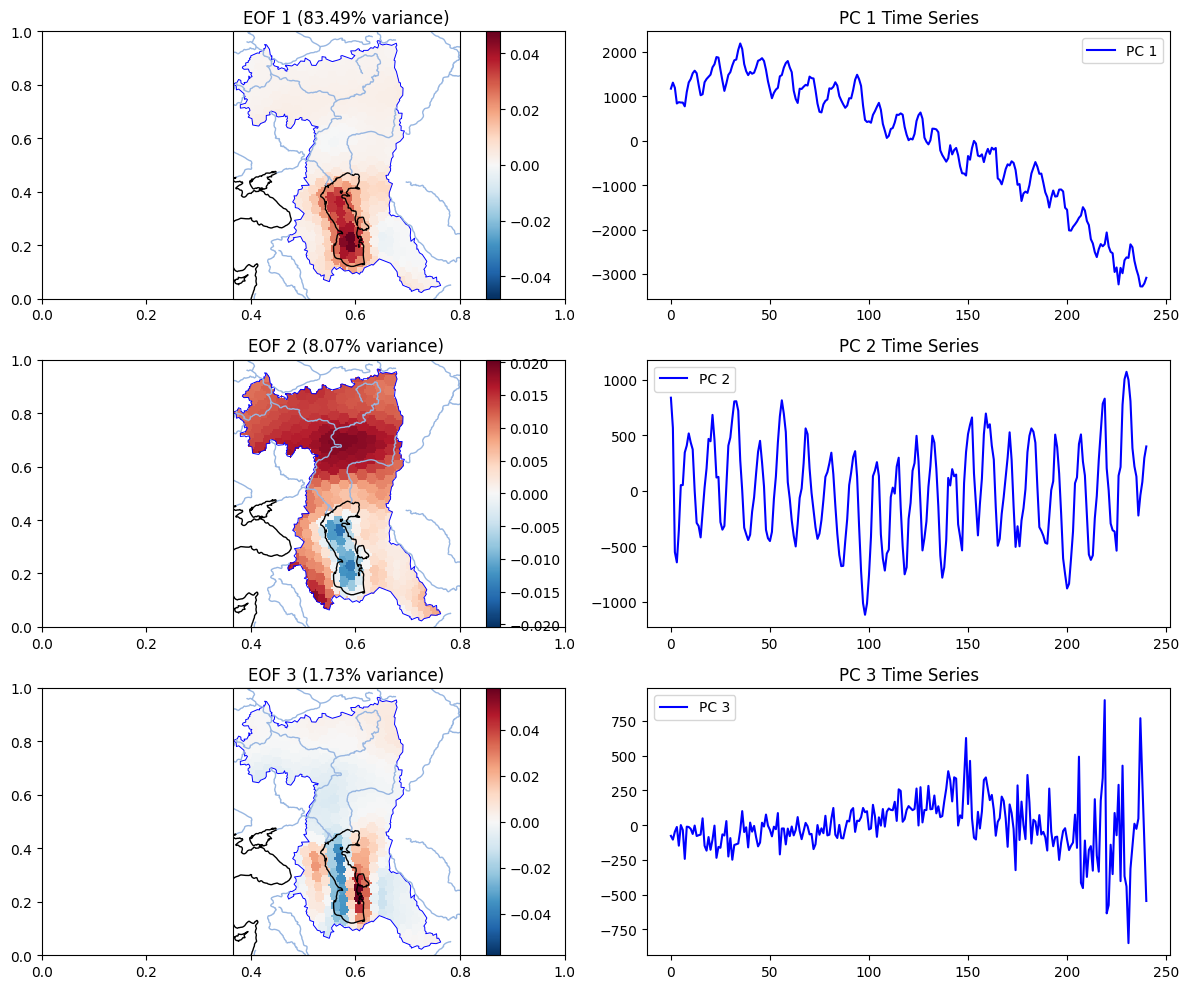

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))  # 3 rows, 2 columns

# Loop over the first 3 EOFs (you may adjust this if you need more components)
for i in range(3):  
    # Create map subplot
    map_ax = fig.add_subplot(3, 2, 2*i+1, projection=ccrs.PlateCarree())

    # Create an empty array for the data, filled with NaNs
    eof_pattern = np.full(final_mask.shape, np.nan)

    # Assign valid values to grid (inside bounding box, Caspian Sea included)
    eof_pattern[final_mask] = pca.components_[i]

    # Mask NaNs for visualization
    eof_pattern = np.ma.masked_invalid(eof_pattern)

    # Get min/max values for color scale
    vmin, vmax = np.min(eof_pattern), np.max(eof_pattern)
    max_range = max(abs(vmin), abs(vmax))

    # Plot EOF pattern
    im = map_ax.pcolormesh(lon_grid, lat_grid, eof_pattern, cmap='RdBu_r', vmin=-max_range, vmax=max_range,
                           shading='auto', transform=ccrs.PlateCarree())

    # Set title with explained variance
    map_ax.set_title(f'EOF {i+1} ({e_var[i]*100:.2f}% variance)')

    # Add geographic features
    map_ax.coastlines()
    map_ax.add_feature(cfeature.RIVERS)

    # Plot the Caspian Basin boundary
    gdf_simplified.plot(ax=map_ax, facecolor='none', edgecolor='blue', linewidth=0.7, transform=ccrs.PlateCarree())

    # Set map extent (bounding box constraint)
    lat_min, lat_max = 33, 63
    lon_min, lon_max = 32, 70
    map_ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Add colorbar
    fig.colorbar(im, ax=map_ax)

    # Plot PC time series
    axes[i, 1].plot(t_data[:, i], label=f'PC {i+1}', color='b')
    axes[i, 1].set_title(f'PC {i+1} Time Series')
    axes[i, 1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()